In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from scipy.interpolate import NearestNDInterpolator

# Creating HWRF Plots
---
## 1. Read .tpc file 
- find lat,lon of center of storm at given hour

In [2]:
#read .tpc file
colspecs = [(5, 10), (18, 25), (32, 38), (56, 63), (89, 95)]
df = pd.read_fwf('/data2/qy2216/HWRF_wind/hwrf.2021072718/nepartak11w/track/NEPARTAK11W.2021072718.stats.tpc', 
                 colspecs=colspecs, header=None, skiprows=12, names=['hour', 'lon', 'lat', 'P', 'V'])
df = df[:41]
df['hour'] = df['hour'].astype(float)
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

---
## 2. Create Polar Plots for each Hour of Storm 
- 2.1 Create Polar Grid
- 2.2 Loop Over Datasets to Prepare and Plot Data
    - Center the data with data from .tpc file (1)
    - Interpolate onto polar grid (2.1)
    - Plot

##### 2.1 Create Polar Grid

In [3]:
#create polar grid
ntheta_pts = 201
nr_pts = 200
rmax = 300

#FIX rmax name
r1 = np.linspace(0, rmax, nr_pts)
theta1 = np.linspace(-np.pi, np.pi, ntheta_pts)

theta2, r2 = np.meshgrid(theta1, r1)

# cartesian coordinates (in km) of the polar coordinates
polar_x2 = r2 * np.cos(theta2)
polar_y2 = r2 * np.sin(theta2)

##### 2.2 Loop Over Datasets to Prepare and Plot Data

In [4]:
#Create Interpolate Function

def makeInterp(dsi, i, gridx = polar_x2, gridy = polar_y2):
    zi = dsi.APCP_surface.isel(time=0).values
    loni = dsi.longitude.values
    lati = dsi.latitude.values
    xcenteri = df[df.hour == i].lon.values[0]
    ycenteri = df[df.hour == i].lat.values[0]
    xi1 = (loni - xcenteri)*np.cos(np.deg2rad(ycenteri))*110.567
    yi1 = (lati - ycenteri)*110.567
    xi2,yi2 = np.meshgrid(xi1,yi1)
    # number of points X 2 matrix of x y
    xyi = np.stack((xi2.flatten(), yi2.flatten())).T

    interpi = NearestNDInterpolator(xyi, zi.flatten())
    Zi = interpi(gridx, gridy)
    return Zi

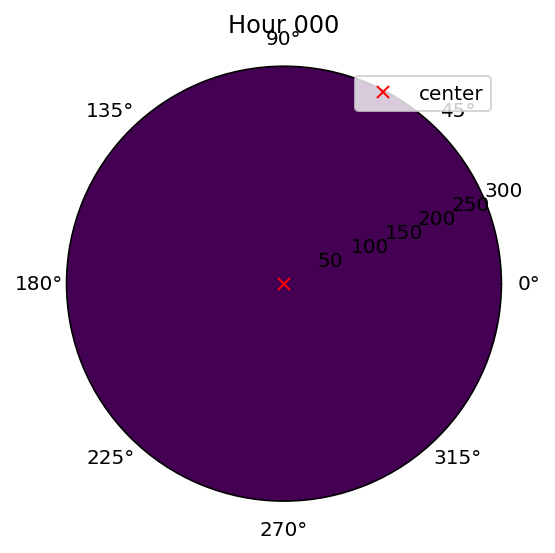

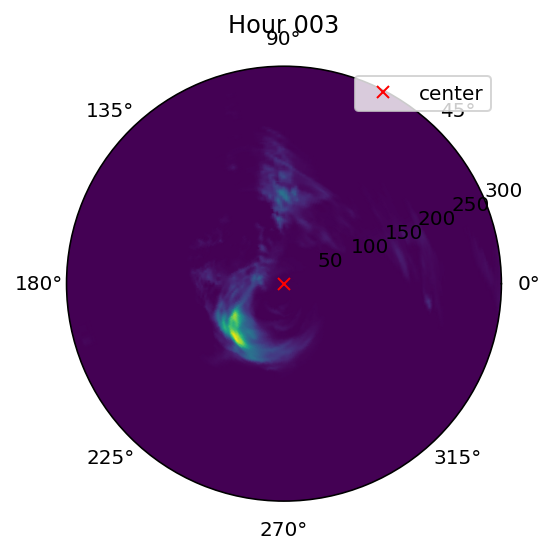

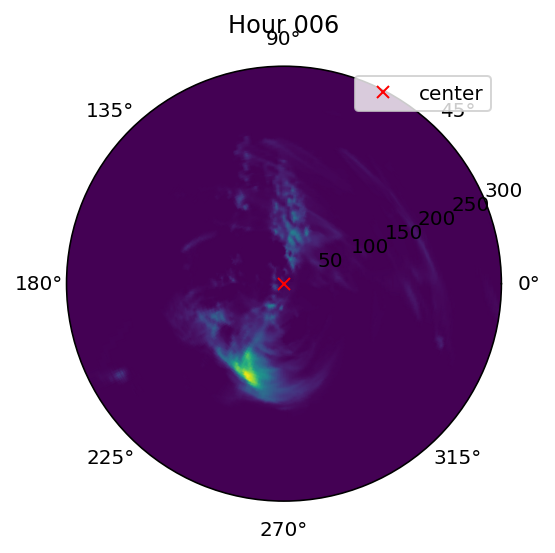

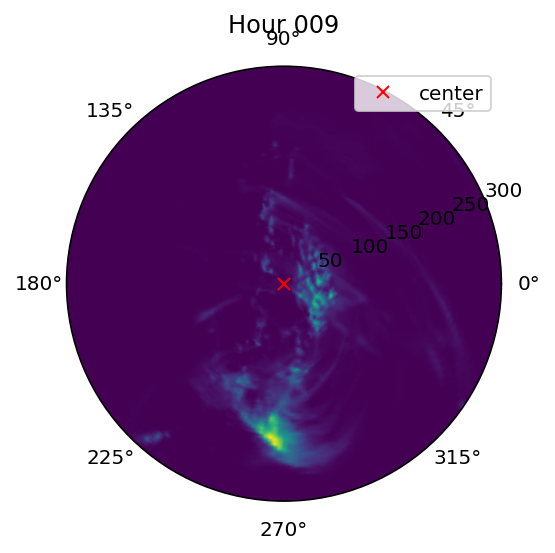

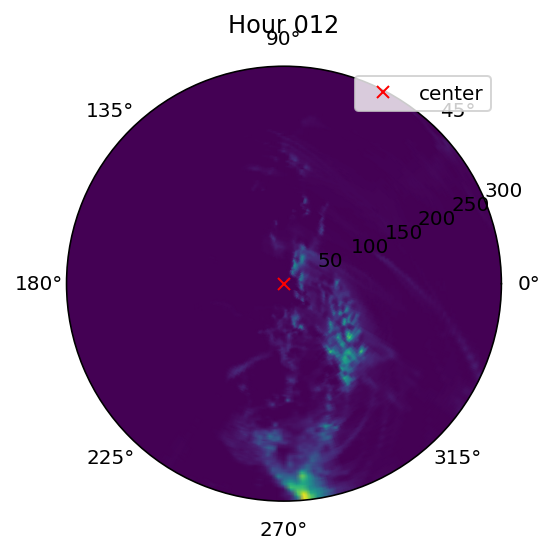

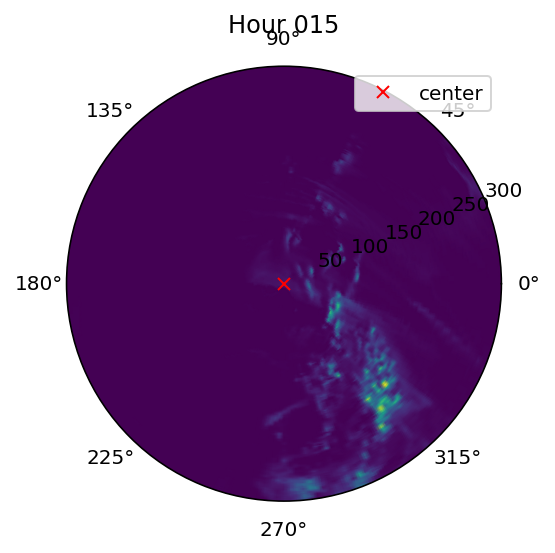

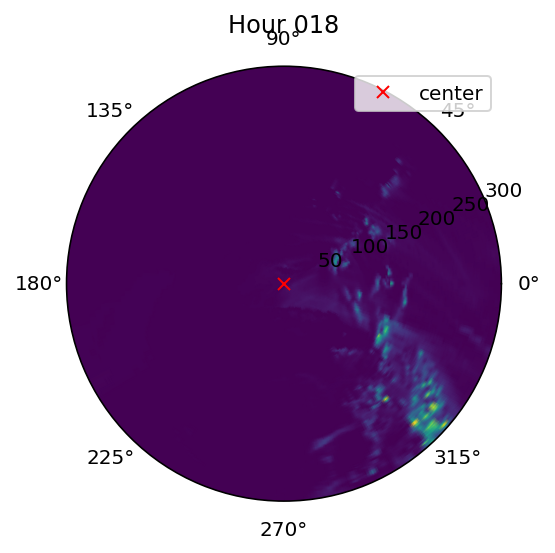

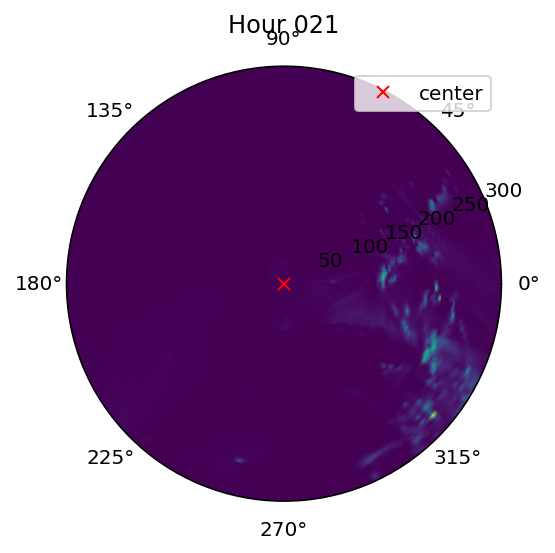

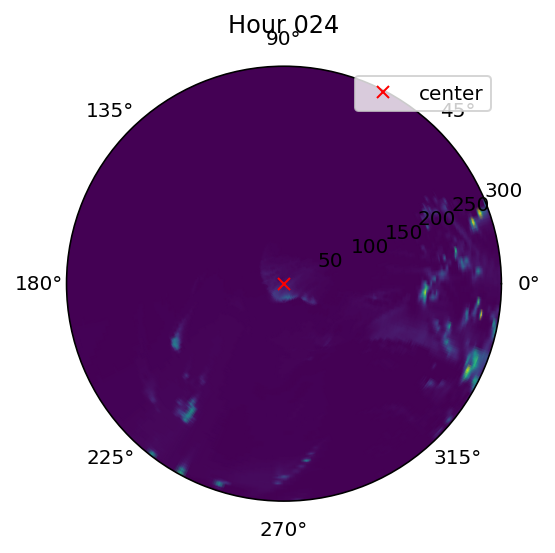

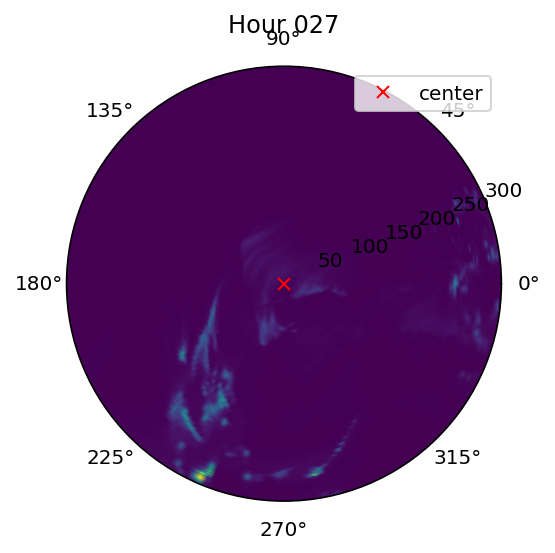

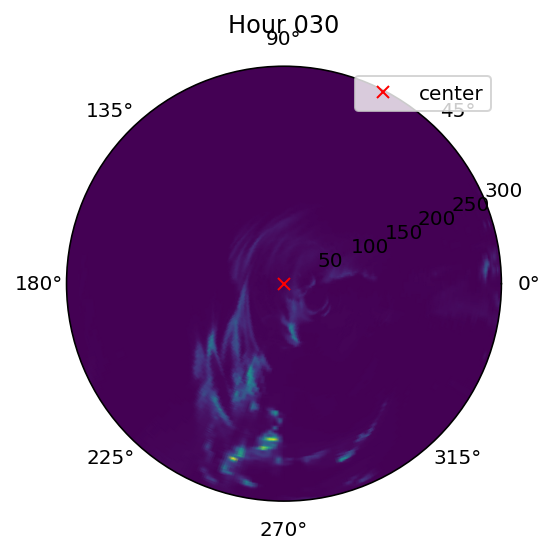

In [6]:
#Loop and plot multiple hours of the storm
startHour = 0
endHour = 33
stepHour = 3

for i,j in enumerate(range(startHour,endHour,stepHour)):
    #print('%03d' % i)
    hour = '%03d' % j
    dsi = xr.open_dataset('/data2/qy2216/HWRF_wind/hwrf.2021072718/nepartak11w/nc/nepartak11w.2021072718.f'+ hour+'.nc')
    #print(dsi)
    Zi = makeInterp(dsi, j)

    plt.figure()
    plt.subplot(projection="polar")
    plt.pcolormesh(theta1, r1, Zi, shading='gouraud')
    plt.plot(0, 0, 'rx', label='center')
    plt.title("Hour " + hour)
    plt.legend()
    
plt.gca().set_aspect('equal')
plt.show()

---
## 3. Superimposed Plot of Centered Data
- 3.1 Create plot for superimposed centered data
    - Make array containing the datasets from startHour to endHour
    - Use np.sum() to find total rainfall
    - Plot total rainfall
- 3.2 Create plot for mean fainfall fates (figure 11 of 2004 Lonfat et al.)

##### 3.1 Create plot for superimposed centered data

In [8]:
#make array containing the datasets from startHour to endHour
numData = 11
dataarray = np.zeros(numData, dtype=np.ndarray)

for i,j in enumerate(range(startHour,endHour,3)):
    hour = '%03d' % j  
    dsi = xr.open_dataset('/data2/qy2216/HWRF_wind/hwrf.2021072718/nepartak11w/nc/nepartak11w.2021072718.f'+ hour+'.nc')
    #print(dsi)
    dataarray[i] = makeInterp(dsi, j, polar_x2, polar_y2) 

#find total rainfall
centeredCum = np.sum(dataarray, axis=0)

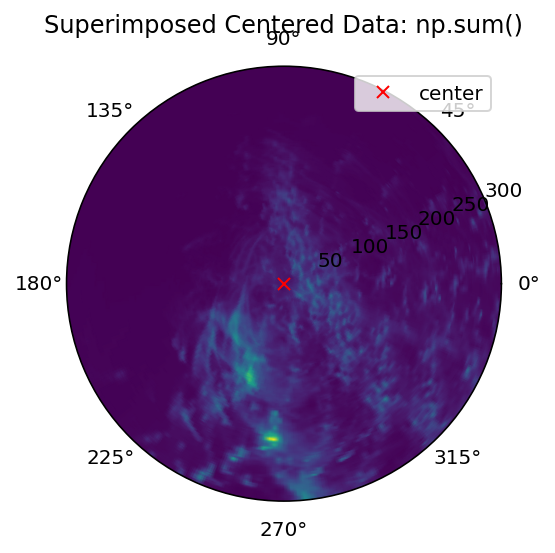

In [10]:
#Plot total rainfall
plt.figure()
plt.subplot(projection="polar")
plt.pcolormesh(theta1, r1, centeredCum, shading='gouraud')
plt.plot(0, 0, 'rx', label='center')
plt.title("Superimposed Centered Data: np.sum()")
plt.legend()

plt.gca().set_aspect('equal')
plt.show()

##### 3.2 Create plot for mean fainfall fates (figure 11 of 2004 Lonfat et al.)

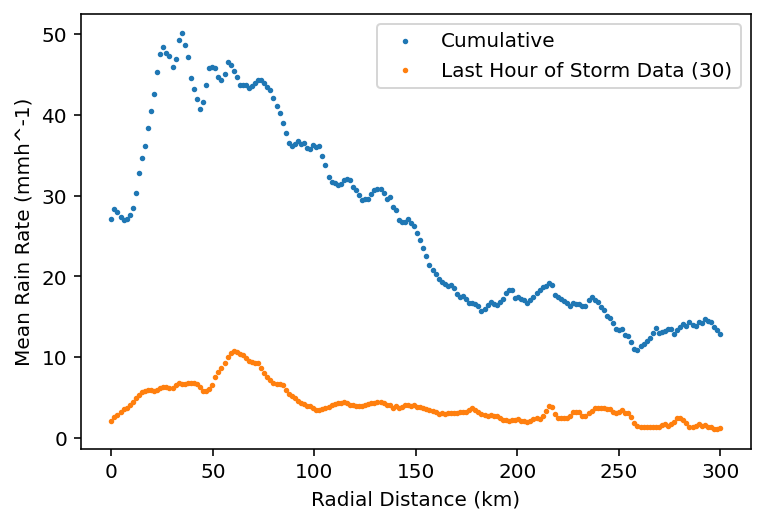

In [14]:
meanRainfallTotal = np.mean(centeredCum, axis=1) #mean rainfall of the total data
meanRainfallEnd = np.mean(dataarray[numData-1], axis=1) #mean rainfall of the last hour of given datasets

plt.scatter(r1,meanRainfallTotal,s=3, label = "Cumulative")
plt.scatter(r1,meanRainfallEnd,s=3, label = "Last Hour of Storm Data (30)")
plt.xlabel("Radial Distance (km)")
plt.ylabel("Mean Rain Rate (mmh^-1)")
plt.legend()
plt.show()

---
## 4. Sumperimposed Plot of Moving Center Data